In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = False
k = 3

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt"
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


TODO:
*  softplus or relu for last classification step?

In [3]:
#Dense/Diffpool Model
import torch.nn.functional as F
import torch_geometric.nn as tgnn
import math

class GNN(th.nn.Module):
    def __init__(self, in_c, hidden_c, out_c): #, lin=True): #, normalize=False
        self.in_c = in_c
        self.hidden_c = hidden_c
        self.out_c = out_c
        super(GNN, self).__init__()
    
        self.conv = th.nn.ModuleList()
        self.bn = th.nn.ModuleList()

        self.conv.append(tgnn.DenseGraphConv(self.in_c, self.hidden_c)) #DenseGCNConv # , normalize
        self.bn.append(th.nn.LayerNorm(self.hidden_c)) #BatchNorm1d(self.hidden_c))

        self.conv.append(tgnn.DenseGraphConv(self.hidden_c, self.hidden_c)) #, normalize
        self.bn.append(th.nn.LayerNorm(self.hidden_c)) #BatchNorm1d(self.hidden_c))

        self.conv.append(tgnn.DenseGraphConv(self.hidden_c, self.out_c)) #, normalize
        self.bn.append(th.nn.LayerNorm(self.out_c)) #BatchNorm1d(self.out_c))

    def forward(self, x, adj, mask=None):
        #batch_size, num_nodes, in_channels = x.size()
        
        for step in range(len(self.conv)):
            x = F.elu(self.conv[step](x, adj, mask))
            x = self.bn[step](x)
        
        return x


#Coarse Grain RNA Classifier Model
class Diff_CG_Classifier(th.nn.Module):
    def __init__(self, num_node_feats):
        self.num_node_feats = num_node_feats
        super(Diff_CG_Classifier, self).__init__()

        num_nodes = math.ceil(0.25 * 64)
        self.gcn_pool1 = GNN(self.num_node_feats, 64, num_nodes)
        self.gcn_embed1 = GNN(self.num_node_feats, 64, 64)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool2 = GNN(64, 64, num_nodes)
        self.gcn_embed2 = GNN(64, 64, 64) #, lin=False)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool3 = GNN(64, 64, num_nodes)
        self.gcn_embed3 = GNN(64, 64, 64) #, lin=False)

        self.gcn_embed4 = GNN(64, 64, 64) #, lin=False)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(64, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )
        self.pos = th.nn.ReLU()#th.nn.Softplus(threshold=1)

    def forward(self, data, training=False):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        adj = data.adj

        s = self.gcn_pool1(x, adj)
        x = self.gcn_embed1(x, adj)

        x, adj, l1, e1 = tgnn.dense_diff_pool(x, adj, s)
        l = l1
        e = e1

        s = self.gcn_pool2(x, adj)
        x = self.gcn_embed2(x, adj)

        x, adj, l2, e2 = tgnn.dense_diff_pool(x, adj, s)
        l+=l2
        e+=e2

        s = self.gcn_pool3(x, adj)
        x = self.gcn_embed3(x, adj)

        x, adj, l3, e3 = tgnn.dense_diff_pool(x, adj, s)
        l+=l3
        e+=e3

        x = self.gcn_embed4(x, adj)

        #x = tgnn.global_mean_pool(x, batch)
        x = x.mean(dim=1)

        x = self.classify(x)
        
        return x, l, e #relu?

        if training:
            return x, l, e #relu?
        else:
            return self.pos(x), l, e

Epoch 0: Training loss 12.6718, Validation loss 13.1639, learning rate: 0.00100
	 prediction loss: 0.0688, entropy regularization 3.4184
Epoch 5: Training loss 5.1000, Validation loss 12.9093, learning rate: 0.00100
	 prediction loss: 0.1112, entropy regularization 2.1375
Epoch 10: Training loss 4.1354, Validation loss 13.2780, learning rate: 0.00100
	 prediction loss: 0.1084, entropy regularization 2.1054
Epoch 15: Training loss 3.2608, Validation loss 13.6804, learning rate: 0.00100
	 prediction loss: 0.1055, entropy regularization 2.0293
Epoch 20: Training loss 2.6089, Validation loss 13.9240, learning rate: 0.00100
	 prediction loss: 0.1038, entropy regularization 2.0468
Epoch 25: Training loss 2.2751, Validation loss 14.5793, learning rate: 0.00099
	 prediction loss: 0.1144, entropy regularization 2.0939
Epoch 30: Training loss 2.1158, Validation loss 14.4829, learning rate: 0.00099
	 prediction loss: 0.1132, entropy regularization 2.0386
Epoch 35: Training loss 1.8103, Validation

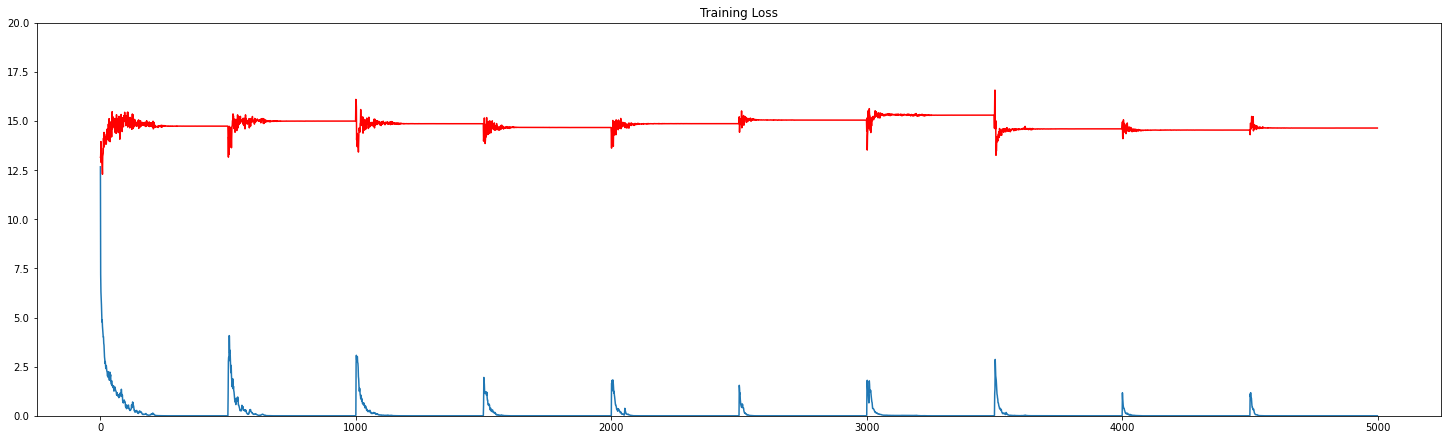

In [4]:
#Training
import time
start = time.perf_counter()

num_node_feats = training_dataset.num_node_features

model = Diff_CG_Classifier(num_node_feats).to(device)

b_size = 128
train_dataloader = DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True) #DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True) #
val_dataloader = DenseDataLoader(val_dataset, batch_size=b_size) #DenseDataLoader(val_dataset, batch_size=b_size) #

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=500)
model.train()

epochs = 5000

def training_loop(model, learning_rates, train_dataloader, scheduler, opt):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data, model.training) #, l, e
        loss = F.smooth_l1_loss(pred, data.y, reduction='mean') #(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    return epoch_loss, l, e

@th.no_grad()
def val_loop(model, val_dataloader):
    model.eval()
    val_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred, _, _ = model(v_data)
        v_loss = F.smooth_l1_loss(val_pred, v_data.y, reduction='mean') #(th.reshape(val_pred, (-1,)), v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    return val_loss

#training setup
epoch_losses = []
val_losses = []
learning_rates = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data, model.training) #, l, e
        loss = F.smooth_l1_loss(pred, data.y, reduction='mean') #(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    #epoch_loss, l, e = training_loop(model, learning_rates, train_dataloader, scheduler, opt)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = val_loop(model, val_dataloader)
    val_losses.append(val_loss)
    
    
    th.save(model.state_dict(), "pyg_diff_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        print("\t prediction loss: {:.4f}, entropy regularization {:.4f}".format(l, e))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss (after 50 epochs) {:.4f} in epoch {}".format(min(val_losses[50:]), val_losses.index(min(val_losses[50:]))))

#plot the training run
figure, ax = plt.subplots(layout='constrained', figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, 'r')
plt.title("Training Loss")
ax.set_ybound(lower=0, upper=20)
plt.draw()

In [5]:
#store training run data

file = "pyg_k3-diff_loss_data_2022-03-24.txt"

with open("loss_data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [3]:
#get training run data

file = "pyg_diffpool_loss_data_2022-03-07.txt"

file_lines = []
with open("loss_data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss (after 50 epochs) {:.4f} in epoch {}".format(min(val_losses[50:]), val_losses.index(min(val_losses[50:]))))


FileNotFoundError: [Errno 2] No such file or directory: 'data/pyg_vec-diffpool_loss_data_2022-03-07.txt'

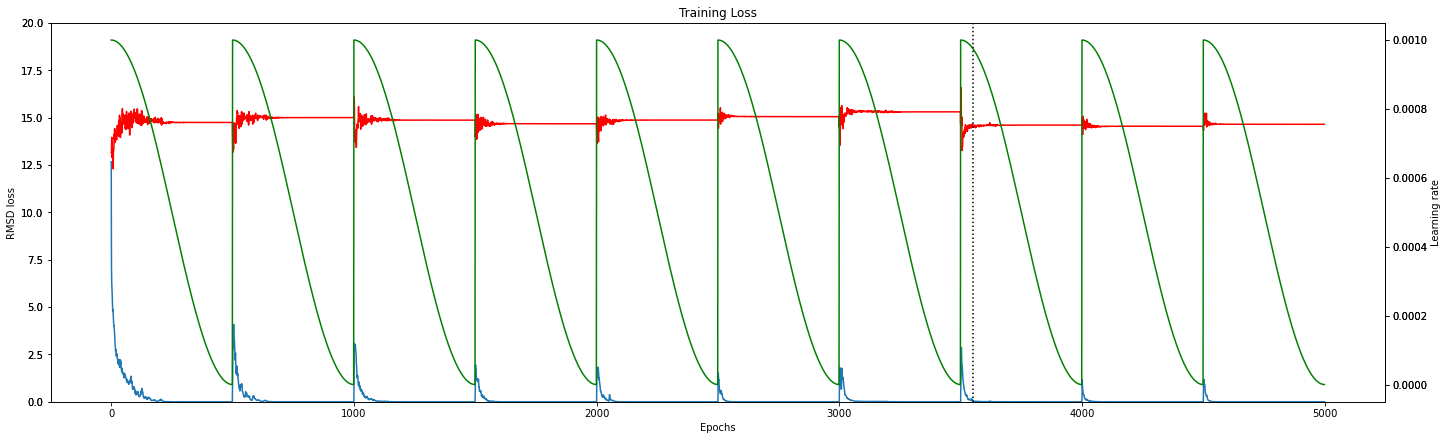

In [7]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(20, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = 3550, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [9]:
#Test Loop
import math
from pyg_classifier.utility import loss_plot, rmsd_scatter, e_rmsd_scatter

@th.no_grad()
def test_loop(model, loader, e_dict, title):
    model.eval()
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    true_rmsds = []
    pred_rmsds = []
    energies = []
    trmsds_f_en = []
    prmsds_f_en = []
    for test_graph in loader:
        test_graph = test_graph.to(device)
        test_pred, _, _ = model(test_graph)
        test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item() # l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #
        test_losses.append(float(test_loss))
        true_rmsds.append(float(test_graph.y))
        pred_rmsds.append(float(test_pred))

        if test_graph.name[0] in e_dict.keys():
            energies.append(e_dict[test_graph.name[0]])
            prmsds_f_en.append(float(test_pred))
            trmsds_f_en.append(float(test_graph.y))
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_graph.y
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_graph.y
            min_pred = test_pred
        if test_pred < 0:
            print(test_graph.y, test_pred)
    
    print(title)
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))
    
    loss_plot(test_losses, test_fq, test_median, test_tq, title + ", Sorted Test Losses")
    rmsd_scatter(pred_rmsds, true_rmsds, title)
    e_rmsd_scatter(energies, trmsds_f_en, title + ", True RMSDs vs Energy")
    e_rmsd_scatter(energies, prmsds_f_en, title + ", Predicted RMSDs vs Energy")
    return energies, trmsds_f_en, prmsds_f_en

Test Set
tensor([[21.3970]], device='cuda:0') tensor([[21.3720]], device='cuda:0') 0.0003129674878437072
tensor([[0.]], device='cuda:0') tensor([[31.8996]], device='cuda:0') 31.39963722229004
Mean Test loss: 	 12.1253
Std. Dev. of Test loss:  9.0746
Min loss: 		 0.0003
First Quantile: 	 5.0780
Median: 		 10.1697
Third Quantile: 	 18.8613
Max Loss: 		 31.3996


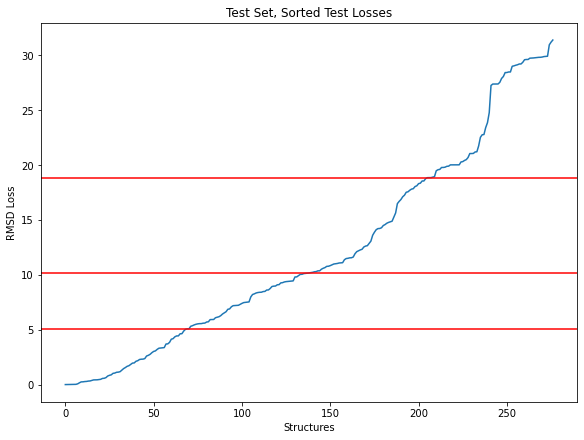

LinregressResult(slope=-1.3350574001517783, intercept=45.13772086481633, rvalue=-0.4406455841347458, pvalue=1.3806672779598629e-14, stderr=0.16400847139899902, intercept_stderr=3.5457087429925953)


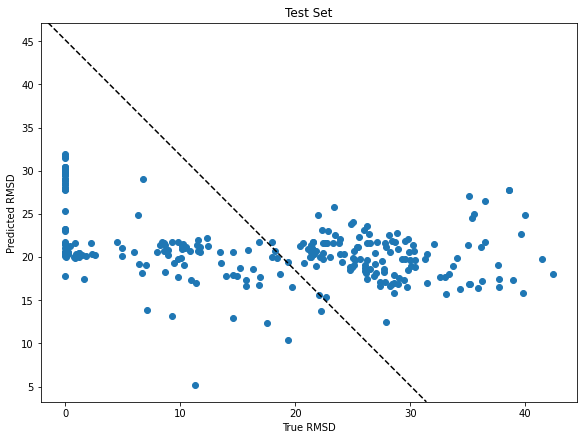

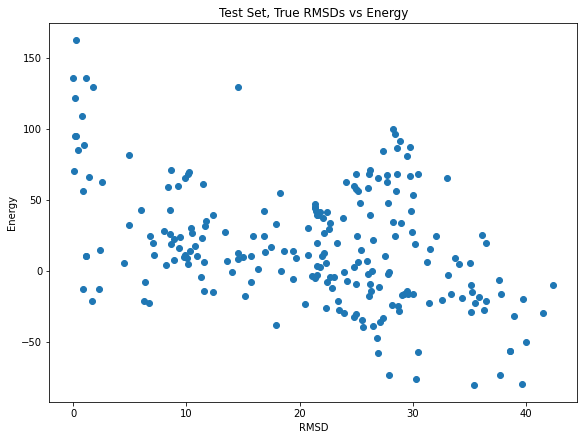

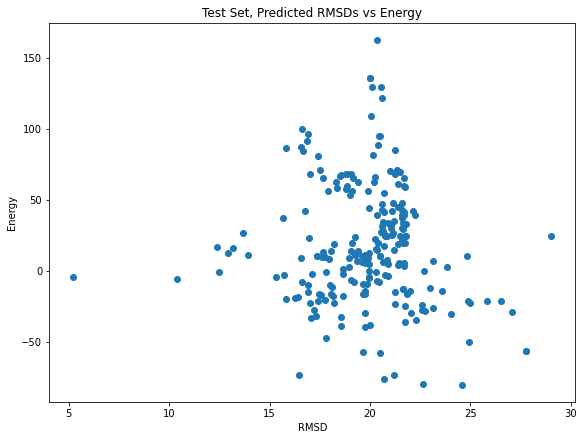

tensor([[0.]], device='cuda:0') tensor([[-20.3727]], device='cuda:0')
tensor([[24.5210]], device='cuda:0') tensor([[-47.5533]], device='cuda:0')
tensor([[23.2360]], device='cuda:0') tensor([[-52.0068]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-20.3727]], device='cuda:0')
tensor([[18.8100]], device='cuda:0') tensor([[-29.1152]], device='cuda:0')
tensor([[21.1380]], device='cuda:0') tensor([[-44.3157]], device='cuda:0')
tensor([[16.4340]], device='cuda:0') tensor([[-31.2573]], device='cuda:0')
tensor([[15.4580]], device='cuda:0') tensor([[-41.1796]], device='cuda:0')
tensor([[15.4830]], device='cuda:0') tensor([[-57.6796]], device='cuda:0')
tensor([[20.4450]], device='cuda:0') tensor([[-48.6957]], device='cuda:0')
5S and tRNA Test Set
tensor([[3.4030]], device='cuda:0') tensor([[3.4033]], device='cuda:0') 3.9106254234866356e-08
tensor([[23.2360]], device='cuda:0') tensor([[-52.0068]], device='cuda:0') 74.74275970458984
Mean Test loss: 	 6.1613
Std. Dev. of Test loss:  9

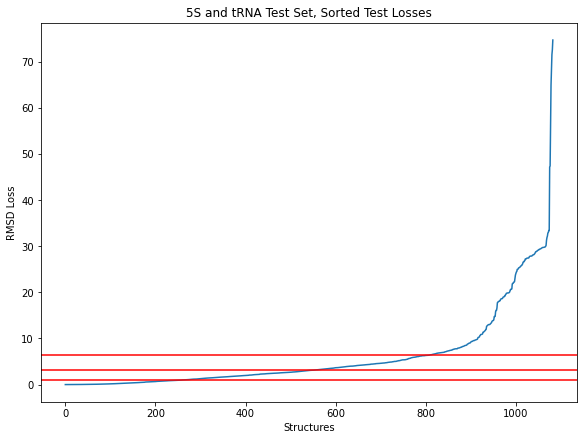

LinregressResult(slope=0.25615324015903085, intercept=11.194505573093059, rvalue=0.260472897646378, pvalue=2.9639473431920574e-18, stderr=0.02887807691506493, intercept_stderr=0.5910876315253966)


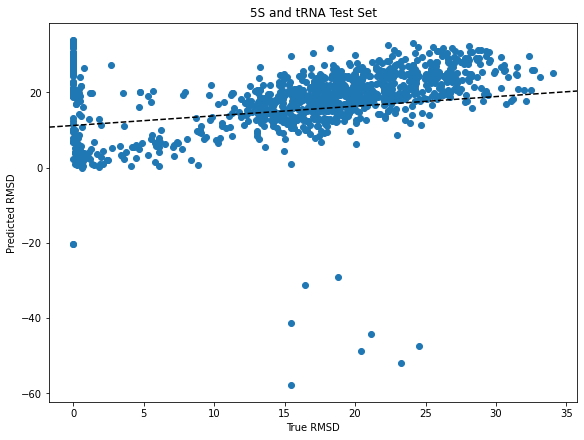

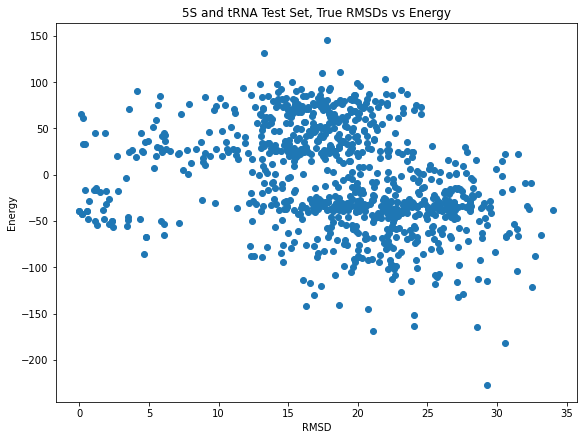

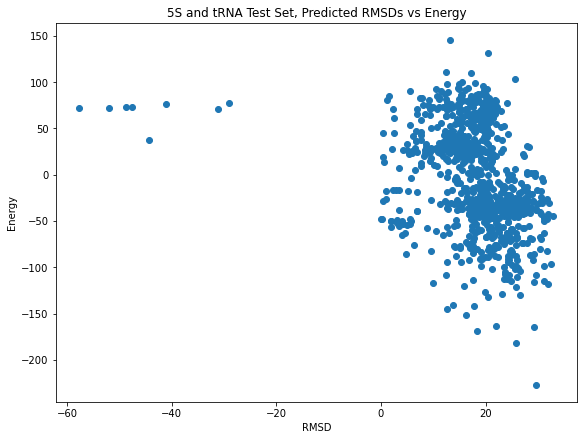

tensor([[0.]], device='cuda:0') tensor([[-0.0012]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0012]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0279]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0279]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0050]], device='cuda:0')
tensor([[0.0140]], device='cuda:0') tensor([[-0.0052]], device='cuda:0')
Training Set
tensor([[17.3680]], device='cuda:0') tensor([[17.3680]], device='cuda:0') 4.092726157978177e-10
tensor([[16.6380]], device='cuda:0') tensor([[16.4889]], device='cuda:0') 0.011118436232209206
Mean Test loss: 	 0.0002
Std. Dev. of Test loss:  0.0006
Min loss: 		 0.0000
First Quantile: 	 0.0000
Median: 		 0.0000
Third Quantile: 	 0.0002
Max Loss: 		 0.0111


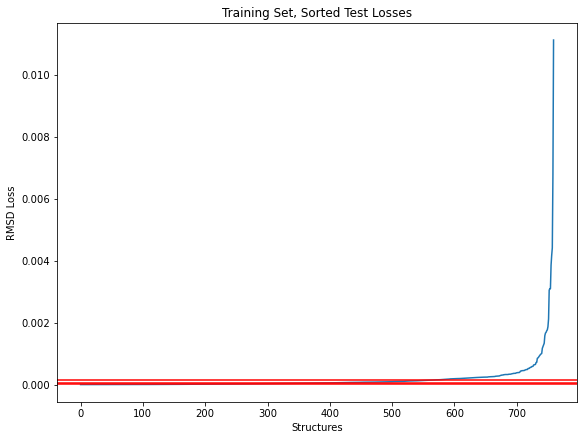

LinregressResult(slope=0.999437434458326, intercept=0.01743718716750564, rvalue=0.999998376899679, pvalue=0.0, stderr=6.540473910960751e-05, intercept_stderr=0.0013153723548578018)


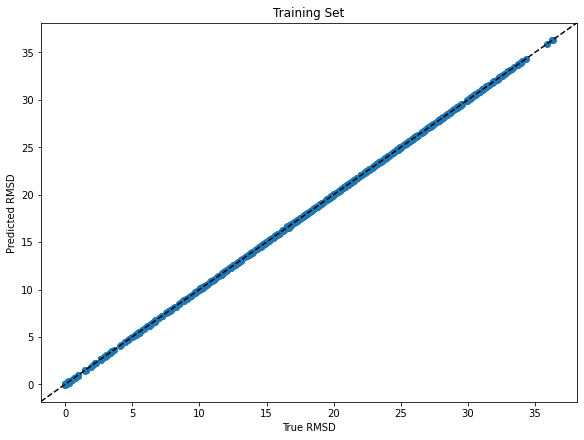

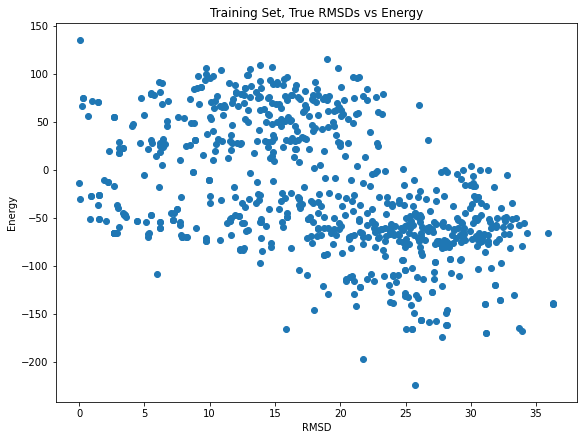

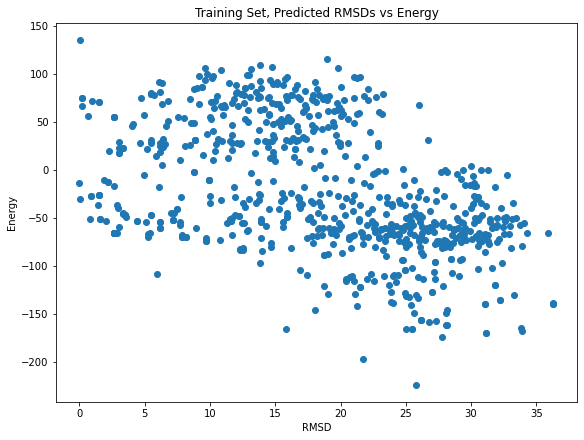

Validation Set
tensor([[17.4640]], device='cuda:0') tensor([[17.4323]], device='cuda:0') 0.0005038408562541008
tensor([[61.9850]], device='cuda:0') tensor([[19.9925]], device='cuda:0') 41.49253845214844
Mean Test loss: 	 14.4495
Std. Dev. of Test loss:  10.1555
Min loss: 		 0.0005
First Quantile: 	 5.4043
Median: 		 13.9459
Third Quantile: 	 21.2877
Max Loss: 		 41.4925


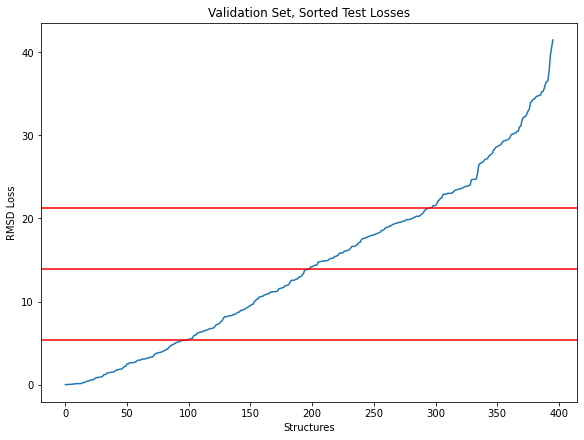

LinregressResult(slope=-0.9357876816903375, intercept=43.6442387862927, rvalue=-0.2821481732295424, pvalue=1.1072771263995926e-08, stderr=0.16030183146998606, intercept_stderr=3.579361493951748)


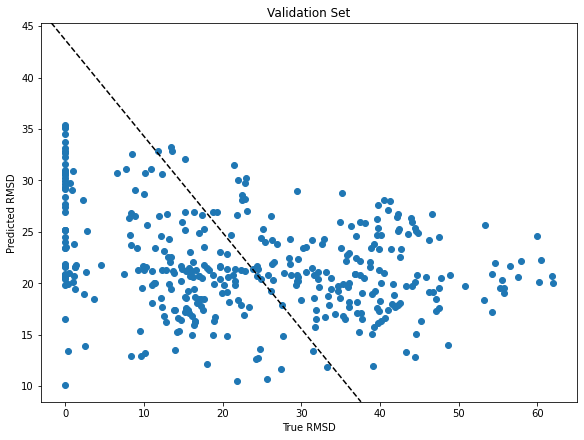

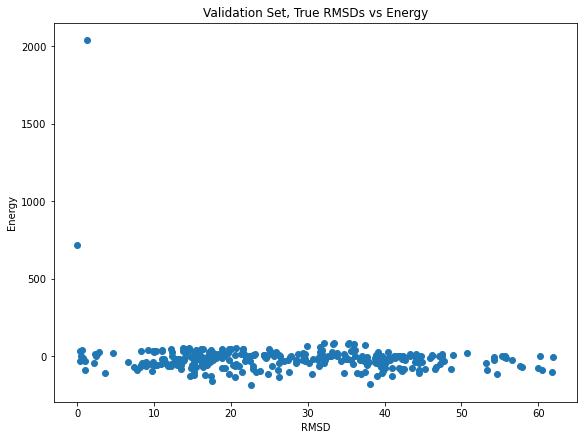

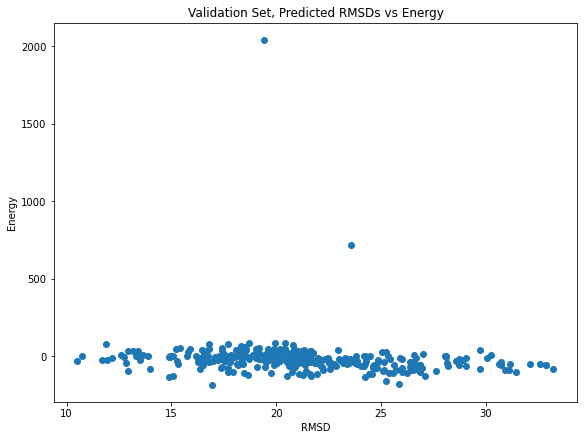

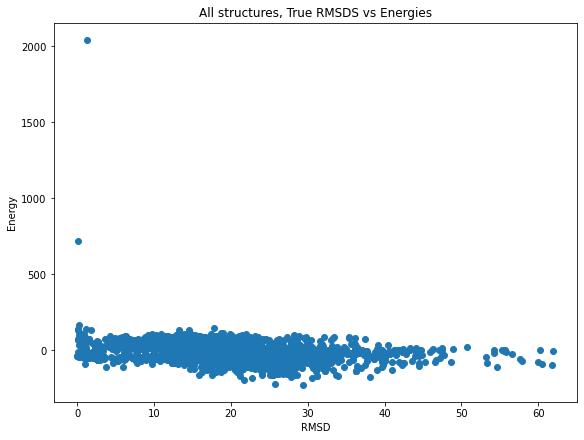

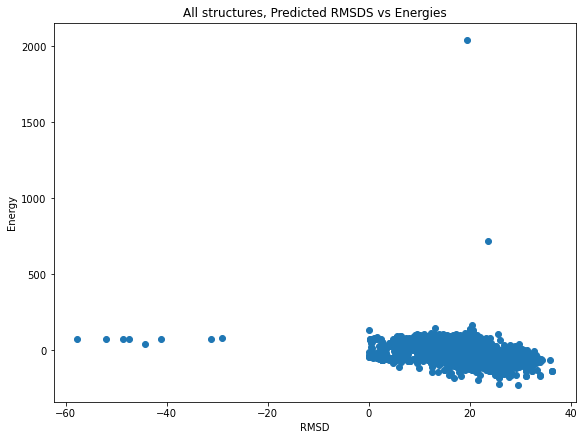

In [14]:
#Test
import math
from pyg_classifier.utility import get_energy_dict

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = Diff_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_diff_model_data/model_epoch4100.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs = test_loop(model, loader, e_dict, title)
    energy_l += en
    true_rmsd_l += trs
    pred_rmsd_l += prs

e_rmsd_scatter(energy_l, true_rmsd_l, "All structures, True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures, Predicted RMSDS vs Energies")

In [12]:
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

Processing...
Done!


LinregressResult(slope=0.07090797599610629, intercept=16.864308534105994, rvalue=0.09041617491343369, pvalue=0.1333306398712714, stderr=0.047097745535355715, intercept_stderr=1.0247403504259505)


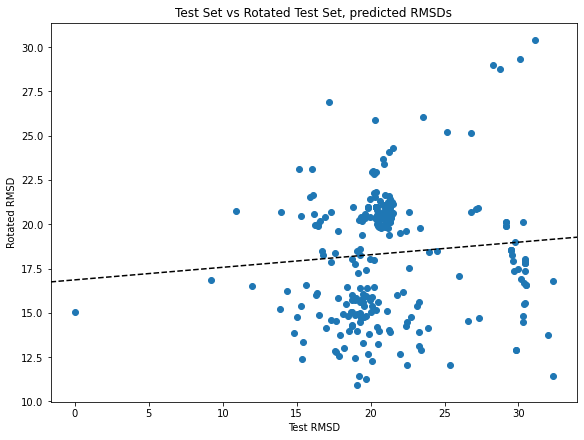

LinregressResult(slope=0.5927145226715048, intercept=4.135486069590699, rvalue=0.7732903987785626, pvalue=2.3814015796784525e-56, stderr=0.02930633376266544, intercept_stderr=0.4490736570114368)


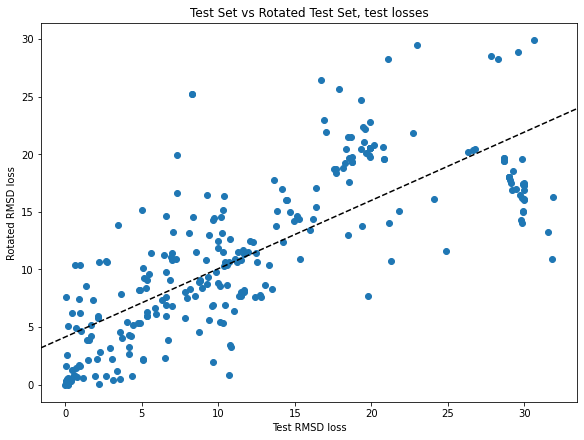

In [13]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)

pred_dir = {}
loss_dir = {}
for loader in [test_dataloader, rot_test_dataloader]:
    with th.no_grad():
        model.eval()
        for test_graph in loader:
            test_graph = test_graph.to(device)
            test_pred, _, _ = model(test_graph)
            test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

            if test_graph.name[0] not in pred_dir.keys():
                pred_dir[test_graph.name[0]] = [float(test_pred)]
            else:
                pred_dir[test_graph.name[0]].append(float(test_pred))
            
            if test_graph.name[0] not in loss_dir.keys():
                loss_dir[test_graph.name[0]] = [float(test_loss)]
            else:
                loss_dir[test_graph.name[0]].append(float(test_loss))

test_preds = []
trot_preds = []
for a in pred_dir.keys():
    test_preds.append(pred_dir[a][0])
    trot_preds.append(pred_dir[a][1])

test_ls = []
trot_ls = []
for b in loss_dir.keys():
    test_ls.append(loss_dir[b][0])
    trot_ls.append(loss_dir[b][1])

reg = linregress(test_preds, trot_preds)
print(reg)

fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
plt.title("Test Set vs Rotated Test Set, predicted RMSDs")
axs1.scatter(test_preds, trot_preds)
axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
plt.xlabel("Test RMSD")
plt.ylabel("Rotated RMSD")
plt.show()

reg_l = linregress(test_ls, trot_ls)
print(reg_l)

fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
plt.title("Test Set vs Rotated Test Set, test losses")
axs2.scatter(test_ls, trot_ls)
axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
plt.xlabel("Test RMSD loss")
plt.ylabel("Rotated RMSD loss")
plt.show()
